## Код EDA, сборки признаков и обучения модели

### EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB
None
                 id         label
count  80000.000000  80000.000000
mean   50107.893162      0.277250
std    28857.649778      0.447644
min        0.000000      0.000000
25%    25122.500000      0.000000
50%    50146.500000      0.000000
75%    75064.250000      1.000000
max    99999.000000      1.000000


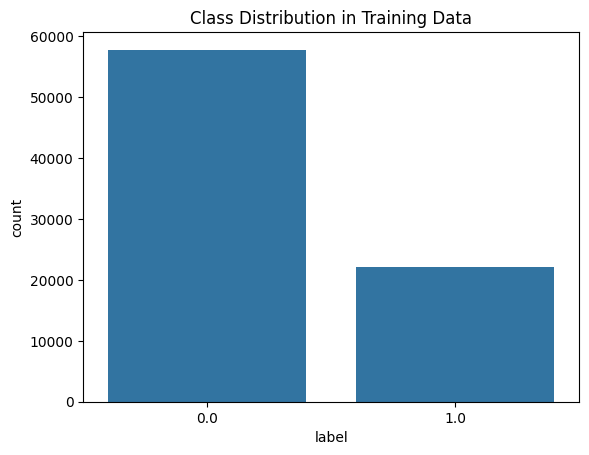

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

# Основная информация о данных
print(train.info())
print(train.describe())

# Проверка баланса классов
sns.countplot(data=train, x='label')
plt.title('Class Distribution in Training Data')
plt.show()

C:\Users\maxmm\AppData\Local\Temp\ipykernel_24032\1205170535.py:2: FutureWarning: using <function <lambda> at 0x0000020C6AE684A0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  duration = train['dates'].agg(lambda x: (x.max() - x.min()).days)


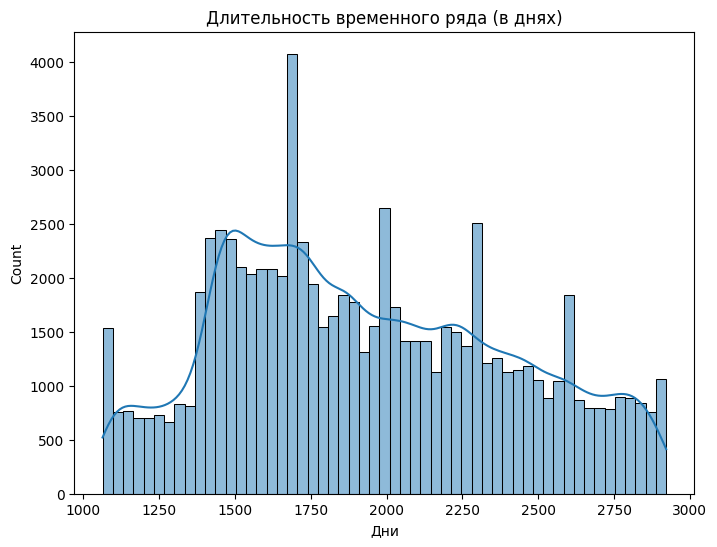

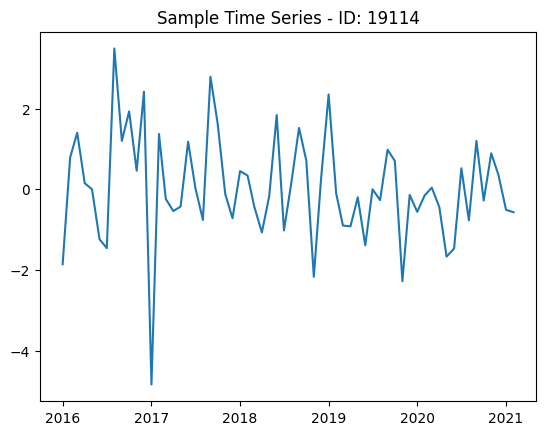

In [203]:
# Длительность временного ряда
duration = train['dates'].agg(lambda x: (x.max() - x.min()).days)
plt.figure(figsize=(8, 6))
sns.histplot(duration, kde=True)
plt.title("Длительность временного ряда (в днях)")
plt.xlabel("Дни")
plt.show()

# Пример визуализации ряда
sample_series = train.iloc[0]
plt.plot(sample_series['dates'], sample_series['values'])
plt.title(f"Sample Time Series - ID: {sample_series['id']}")
plt.show()

### Сборка признаков из временных рядов

In [204]:
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler

def generate_features(df): 
    '''
    Функция для сборки признаков из временных рядов
    Вход: Датафрейм с 2 временными рядами (values и dates)
    Выход: Датафрейм с извлеченными признаками (mean, std, min, max, median, value_range, fft_real_sum, fft_imag_sum, date_range)
    '''
    feature_list = []
    for _, row in df.iterrows():
        values = row['values']
        
        # Статистические признаки временного ряда
        features = {
            'id': row['id'],
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            'value_range': np.max(values) - np.min(values),  # Размах
            'fft_real_sum': np.sum(np.real(fft(values))),
            'fft_imag_sum': np.sum(np.imag(fft(values))),
        }
        
        # Признаки на основе даты
        
        dates = pd.to_datetime(row['dates'])  # Преобразование дат в формат datetime
        features.update({
            'date_range': (dates.max() - dates.min()).days  # Длительность ряда в днях
        })
        
        feature_list.append(features)
    
    return pd.DataFrame(feature_list)

# Генерация признаков для train
train_features = generate_features(train)

# Объединение данных для удаления NaN
train_combined = pd.concat([train_features, train['label']], axis=1)

# Удаление строк с NaN значениями
train_combined = train_combined.dropna()

# Разделение данных обратно на признаки и метки
train_features = train_combined.drop(columns=['label'])
train_labels = train_combined['label']

# Нормализация признаков
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features.drop(columns=['id']))
test_features_scaled = scaler.transform(test_features.drop(columns=['id']))

### Обучение модели

In [205]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(train_features_scaled, train_labels, test_size=0.2, random_state=42)

# Обучение модели
model = GradientBoostingClassifier(random_state=42, learning_rate=0.25, max_depth=3, n_estimators=200)
model.fit(X_train, y_train)

# Оценка на валидационной выборке
val_predictions = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, val_predictions)
print(f'Validation ROC AUC: {roc_auc}')

# Сохранение модели и скейлера
# import joblib
# joblib.dump(model, 'trained_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')

Validation ROC AUC: 0.8418941790829824


['scaler.pkl']

Validation ROC AUC: 0.8418941790829824

In [91]:
# Поиск лучших параметров модели
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Определение модели
model = GradientBoostingClassifier()

# Задание параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Скорость обучения
    'max_depth': [3, 5, 7],  # Максимальная глубина деревьев
}

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train[:20000], y_train[:20000])

# Лучшая модель
best_model = grid_search.best_estimator_

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [211]:
# Итоговое обучение модели на всей тестовой выборке
model = GradientBoostingClassifier(random_state=42, learning_rate=0.25, max_depth=3, n_estimators=200)
model.fit(train_features_scaled, train_labels)

# Сохранение модели и скейлера
import joblib
joblib.dump(model, 'trained_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']